In [1]:
import re
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd

In [2]:
url = 'https://www.amazon.in/b/?_encoding=UTF8&node=976392031&ref_=sv_top_elec_mega_2'
page_url='https://www.amazon.in/b/?_encoding=UTF8&node=976392031&ref_=sv_top_elec_mega_2'

In [3]:
page_url

'https://www.amazon.in/b/?_encoding=UTF8&node=976392031&ref_=sv_top_elec_mega_2'

In [27]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, ElementNotInteractableException, TimeoutException, ElementClickInterceptedException
import time
import re

# Setup the WebDriver for Chrome
options = Options()
options.headless = True

# Initialize WebDriver
try:
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
except Exception as e:
    print(f"Failed to initialize WebDriver: {e}")
    raise

driver.implicitly_wait(10)  # Set implicit wait

# Load the main Amazon URL
url = 'https://www.amazon.in/b/?_encoding=UTF8&node=976392031&ref_=sv_top_elec_mega_2'
driver.get(url)

# Allow time for the page to load
time.sleep(5)

# Define the XPath for the "Load More" button
load_more_xpath = '//*[@id="a-autoid-1"]/span/i'

all_links = []  # List to store all extracted links
new_links_found = True  # Flag to indicate if new links are being found
no_new_links_count = 0  # Counter for iterations with no new links
max_no_new_links = 5  # Maximum allowed iterations without finding new links

try:
    while new_links_found:
        new_links_found = False  # Assume no new links until proven otherwise
        try:
            # Wait for the "Load More" button to be present
            load_more_button = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, load_more_xpath))
            )
            
            # Scroll to the "Load More" button using JavaScript
            driver.execute_script("arguments[0].scrollIntoView(true);", load_more_button)
            time.sleep(2)  # Allow time for any animations or overlays to complete

            # Check if the button is clickable and click it
            WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, load_more_xpath))
            )
            driver.execute_script("arguments[0].click();", load_more_button)
            print("Clicked 'Load More' button.")
            time.sleep(3)  # Allow time for new content to load

            # Extract links from the page
            parent_div = driver.find_element(By.CSS_SELECTOR, 
                "div.a-column.a-span12.aok-float-right.apb-browse-col-pad-left.apb-browse-two-col-center-margin-right.a-span-last")

            target_div = parent_div.find_element(By.CSS_SELECTOR, 
                "div.apb-default-slot.apb-default-merchandised-search-13")

            carousel_container = target_div.find_element(By.CSS_SELECTOR, 
                "div.acsWidgetCarouselV1__carousel-container._carousel_style_carousel-container__2Iapb")

            cardui_deck = carousel_container.find_element(By.CSS_SELECTOR, "div.a-cardui-deck")

            # Extract and print the text from the cardui_deck div
            cardui_text = cardui_deck.text
            # print("Cardui Deck Text:")
            # print(cardui_text)

            # Find the carousel viewport and get all li elements with the specified class
            carousel_viewport = carousel_container.find_element(By.CSS_SELECTOR, "div.a-carousel-viewport")

            carousel_cards = carousel_viewport.find_elements(By.CSS_SELECTOR, 
                "li.a-carousel-card._carousel_style_carousel-element-support__3lVml")

            # Iterate through each li and find all a elements with the specified class
            for card in carousel_cards:
                links = card.find_elements(By.CSS_SELECTOR, "a.a-color-base.a-spacing-none.a-link-normal")
                
                # Open each link in a new tab
                for link in links:
                    href = link.get_attribute('href')
                    if href not in all_links:
                        all_links.append(href)
                        # print(f"Found link: {href}")
                        driver.execute_script(f"window.open('{href}', '_blank');")
                        time.sleep(2)  # Adjust this sleep time if necessary

            if not new_links_found:
                no_new_links_count += 1
                print(f"No new links found. Counter: {no_new_links_count}/{max_no_new_links}")
                if no_new_links_count >= max_no_new_links:
                    print("Maximum no new links reached. Ending.")
                    break

        except (ElementNotInteractableException, ElementClickInterceptedException):
            print("Exception encountered while interacting with the button. Retrying.")
            driver.execute_script("window.scrollBy(0, 250);")  # Scroll down a bit more
        except TimeoutException:
            print("TimeoutException: Timeout waiting for 'Load More' button. Ending pagination.")
            break
        except NoSuchElementException:
            print("NoSuchElementException: No 'Load More' button found. Ending pagination.")
            break

    # Handling carousel navigation if required
    while True:
        try:
            # Locate and click the "Next" button using the given XPath
            next_button = carousel_container.find_element(By.XPATH, "//*[@id='a-autoid-1']/span/i")
            next_button.click()
            # print("Clicked on the Next button...")
            time.sleep(2)  # Wait for the next page to load

            # Extract and print links from the new page
            carousel_cards = carousel_viewport.find_elements(By.CSS_SELECTOR, 
                "li.a-carousel-card._carousel_style_carousel-element-support__3lVml")
            for card in carousel_cards:
                links = card.find_elements(By.CSS_SELECTOR, "a.a-color-base.a-spacing-none.a-link-normal")
                
                # Open each link in a new tab
                for link in links:
                    href = link.get_attribute('href')
                    if href not in all_links:
                        all_links.append(href)
                        # print(f"Found link: {href}")
                        driver.execute_script(f"window.open('{href}', '_blank');")
                        time.sleep(2)  # Adjust this sleep time if necessary

        except (NoSuchElementException, ElementNotInteractableException):
            print("No more pages or unable to click the next button.")
            break

except Exception as e:
    print(f"Exception encountered: {e}")

finally:
    # Print the total number of links found
    print(f"Total number of links found: {len(all_links)}")
    
    # Close the browser after processing
    driver.quit()


Clicked 'Load More' button.
No new links found. Counter: 1/5
Exception encountered: Message: stale element reference: stale element not found in the current frame
  (Session info: chrome=128.0.6613.86); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#stale-element-reference-exception
Stacktrace:
	GetHandleVerifier [0x01188283+26163]
	(No symbol) [0x01119D34]
	(No symbol) [0x010124C3]
	(No symbol) [0x01018064]
	(No symbol) [0x01019BCF]
	(No symbol) [0x01095381]
	(No symbol) [0x0107ACBC]
	(No symbol) [0x01094661]
	(No symbol) [0x0107AA56]
	(No symbol) [0x0104BE89]
	(No symbol) [0x0104C8CD]
	GetHandleVerifier [0x0145CF73+2994979]
	GetHandleVerifier [0x014B17E9+3341209]
	GetHandleVerifier [0x01217B5F+614159]
	GetHandleVerifier [0x0121F1EC+644508]
	(No symbol) [0x0112286D]
	(No symbol) [0x0111F768]
	(No symbol) [0x0111F905]
	(No symbol) [0x01111C86]
	BaseThreadInitThunk [0x75E4FCC9+25]
	RtlGetAppContainerNamedObjectPath 

In [28]:
all_links

['https://www.amazon.in/Kreo-Auto-Focus-Digital-Streaming-Rotation/dp/B0CG372R11/ref=s9_acsd_al_ot_c2_x_3_t?_encoding=UTF8&pf_rd_m=A21TJRUUN4KGV&pf_rd_s=merchandised-search-13&pf_rd_r=XY06N3ZN2QGPFHZEC8PC&pf_rd_p=7707bded-42cf-41f9-9c48-e9d196e346ae&pf_rd_t=&pf_rd_i=976392031',
 'https://www.amazon.in/ViewSonic-Digital-Graphics-Pressure-Battery-Free/dp/B0CH3GZHCV/ref=s9_acsd_al_ot_c2_x_4_t?_encoding=UTF8&pf_rd_m=A21TJRUUN4KGV&pf_rd_s=merchandised-search-13&pf_rd_r=XY06N3ZN2QGPFHZEC8PC&pf_rd_p=7707bded-42cf-41f9-9c48-e9d196e346ae&pf_rd_t=&pf_rd_i=976392031',
 'https://www.amazon.in/Belkin-Essential-F9E400zb1-5MGRY-4-Socket-Protector/dp/B0083T231O/ref=s9_acsd_al_ot_c2_x_5_t?_encoding=UTF8&pf_rd_m=A21TJRUUN4KGV&pf_rd_s=merchandised-search-13&pf_rd_r=XY06N3ZN2QGPFHZEC8PC&pf_rd_p=7707bded-42cf-41f9-9c48-e9d196e346ae&pf_rd_t=&pf_rd_i=976392031',
 'https://www.amazon.in/Logitech-Collaboration-Streaming-Reducing-Microsoft/dp/B0CW96V1Z2/ref=s9_acsd_al_ot_c2_x_7_t?_encoding=UTF8&pf_rd_m=A21TJRUU

In [37]:
len(all_links)

35

In [30]:
!pip install webdriver_manager
!pip install selenium

In [31]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd

# Set up Selenium WebDriver
chrome_options = Options()
chrome_options.add_argument("--headless")  # Run in headless mode for efficiency
driver = webdriver.Chrome(options=chrome_options)

# Lists to store scraped data
data = {
    'Product Name': [],
    'Price': [],
    'Rating': [],
    'Reviews': []
}

# Assuming all_links is a list of URLs
for link in all_links:
    # Use Selenium to get the page source
    driver.get(link)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')

    # Scrape product name
    product_name_span = soup.find('span', {'id': 'productTitle'})
    if product_name_span:
        product_name = product_name_span.get_text(strip=True)
        data['Product Name'].append(product_name)
    else:
        data['Product Name'].append(None)

    # Scrape price
    price_div = soup.find('div', class_='a-section a-spacing-none aok-align-center aok-relative')
    if price_div:
        text = price_div.get_text(strip=True)
        price = re.findall(r'\d+,?\d*', text)
        if price:
            data['Price'].append(price[0])
        else:
            data['Price'].append(None)
    else:
        data['Price'].append(None)

    # Scrape rating
    rating_div = soup.find('span', {'id': 'acrPopover'}) or soup.find('span', {'id': 'averageCustomerReviews'})
    if rating_div:
        rating_text = rating_div.get_text(strip=True)
        rating = re.findall(r'\d+\.\d+', rating_text)
        if rating:
            data['Rating'].append(rating[0])
        else:
            data['Rating'].append(None)
    else:
        data['Rating'].append(None)

    # Scrape reviews
    review_text_element = soup.find('span', {'id': 'acrCustomerReviewText'})
    if review_text_element:
        review_text = review_text_element.get_text(strip=True)
        review_text = review_text.replace("ratings", "").strip()
        data['Reviews'].append(review_text)
    else:
        data['Reviews'].append('Not found')

# Close the Selenium WebDriver
driver.quit()

# Create Pandas DataFrame
df = pd.DataFrame(data)

# Print the final DataFrame
print(df)

                                         Product Name   Price Rating   Reviews
0   Kreo Owl Full HD 1080P 60 FPS Webcam with Auto...   3,769   4.54       284
1   ViewSonic (From USA)33.85 Cm (13.33") FHD Digi...  27,086   3.83        26
2   Belkin 4-Socket Surge Protector Universal Sock...   1,199   4.54    22,558
3   Logitech MX Brio Ultra HD 4K Collaboration and...  22,718   3.63        17
4   JBL Quantum 910 Wireless Over Ear Gaming Heads...  11,999   4.34       833
5   Logitech MX Anywhere 2S Bluetooth Edition Wire...   3,999   3.73         7
6   HP 330 15.6-inch Laptop Backpack/Trolley Pass-...   1,094   4.54       441
7   Dell WM118 Wireless Mouse, 1000DPI, 2.4 Ghz wi...     645   4.24    18,696
8   amazon basics Rechargeable Wireless Mouse with...     729   3.93       989
9   Amkette Optimus Bluetooth 4 in 1 Keyboard with...     899   4.14       164
10  HP H150 Wireless Earbuds, Bluetooth connectivi...   1,395   3.73         9
11  Apple Magic Keyboard - US English - Silver (fo..

In [109]:
df.shape

(34, 4)

In [67]:
df['Reviews'] = df['Reviews'].astype(str)
df['Reviews'] = df['Reviews'].str.replace(',', '').astype(float)

In [81]:
df

,Product Name,Price,Rating,Reviews
0,Kreo Owl Full HD 1080P 60 FPS Webcam with Auto...,"3,769",4.54,284.0
1,"ViewSonic (From USA)33.85 Cm (13.33"") FHD Digi...","27,086",3.83,26.0
2,Belkin 4-Socket Surge Protector Universal Sock...,"1,199",4.54,22558.0
3,Logitech MX Brio Ultra HD 4K Collaboration and...,"22,718",3.63,17.0
4,JBL Quantum 910 Wireless Over Ear Gaming Heads...,"11,999",4.34,833.0
5,Logitech MX Anywhere 2S Bluetooth Edition Wire...,"3,999",3.73,7.0
6,HP 330 15.6-inch Laptop Backpack/Trolley Pass-...,"1,094",4.54,441.0
7,"Dell WM118 Wireless Mouse, 1000DPI, 2.4 Ghz wi...",645,4.24,18696.0
8,amazon basics Rechargeable Wireless Mouse with...,729,3.93,989.0
9,Amkette Optimus Bluetooth 4 in 1 Keyboard with...,899,4.14,164.0


In [93]:
# df=df["Rating"],df["Total Reviews"]
# cor_matrix=df1.corr()
df1=df[df.columns[2:4]]
df1

,Rating,Reviews
0,4.54,284.0
1,3.83,26.0
2,4.54,22558.0
3,3.63,17.0
4,4.34,833.0
5,3.73,7.0
6,4.54,441.0
7,4.24,18696.0
8,3.93,989.0
9,4.14,164.0


In [95]:
corr_matrix=df1.corr()
corr_matrix
# i want scatter plot x='Rating',y='Total Reviews'

,Rating,Reviews
Rating,1.000000,0.214981
Reviews,0.214981,1.000000


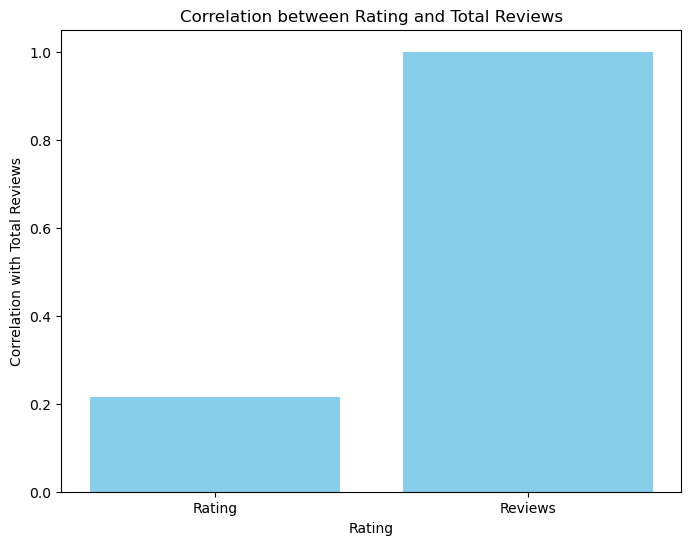

In [99]:
import matplotlib.pyplot as plt

# assuming corr_matrix is your correlation matrix

plt.figure(figsize=(8,6))
plt.bar(corr_matrix.index, corr_matrix['Reviews'], color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Correlation with Total Reviews')
plt.title('Correlation between Rating and Total Reviews')
plt.show()

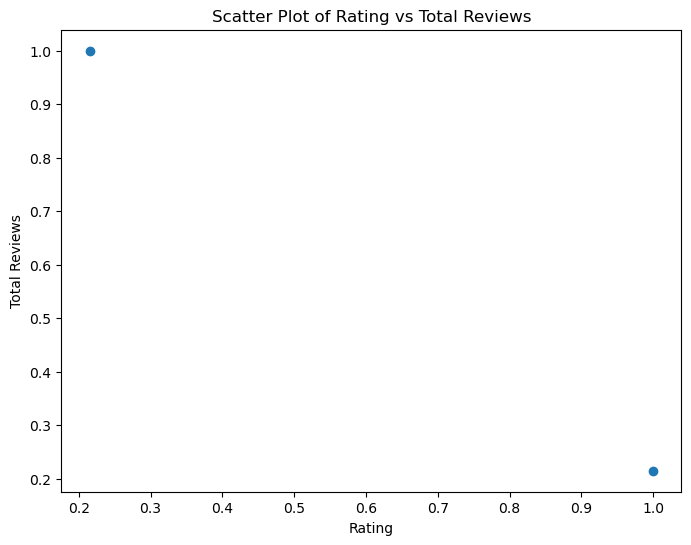

In [103]:
import matplotlib.pyplot as plt

# assuming df1 is your DataFrame

plt.figure(figsize=(8,6))
plt.scatter(corr_matrix['Rating'], corr_matrix['Reviews'])
plt.xlabel('Rating')
plt.ylabel('Total Reviews')
plt.title('Scatter Plot of Rating vs Total Reviews')
plt.show()

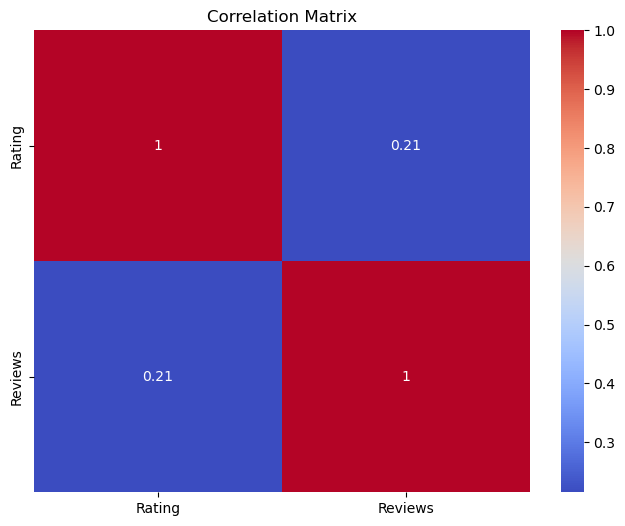

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# assuming corr_matrix is your correlation matrix

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()